<small><img src=https://raw.githubusercontent.com/ia4legos/MachineLearning/main/images/IASAC-UMH.png width="450" height="200"></small>

# <font color="steelblue">Modelos de regresión logística multinomial</font>

**Autoría**: 

*   Fernando Borrás (f.borras@umh.es)
*   Federico Botella (federico@umh.es)
*   Inés Hernández (ines.hernandezp@umh.es)
*   Mª Asunción Martínez Mayoral (asun.mayoral@umh.es)
*   Josep Moltó (j.molto@umh.es)
*   Javier Morales (j.morales@umh.es) 

Departamento de Estadística, Matemáticas e Informática. 

Universidad Miguel Hernández de Elche. 


**Financiación**: El material que aparece a continuación se ha desarrollado dentro del marco del proyecto UNIDIGITAL- IASAC.

**Fecha última edición**: 01/03/2023

**Licencia**: <small><a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br /></small>

No olvides hacer una copia si deseas utilizarlo. Al usar estos contenidos, acepta nuestros términos de uso y nuestra política de privacidad. 


## <font color="steelblue">Configuración del cuaderno</font>

Para garantizar la funcionalidad completa de este cuaderno, es preciso ejecutar la celda de código a continuación.

In [ ]:
#@title <b><font color="steelblue" size="+1"> Configuración de cuaderno

# Cargamos módulos
from io import StringIO 
import sys
import numpy as np      # importamos numpy como np
import pandas as pd     # importamos pandas como pd
import math             # importamos módulo para cáculos matemáticos

# Esta línea configura matplotlib para mostrar las figuras incrustadas en el jupyter notebook
# Configuraciónde entorno gráfico
%matplotlib inline
import matplotlib.pyplot as plt # importamos matplotlib como plt
import seaborn as sns # importamos seaborn como sns
sns.set_style("ticks")
%config InlineBackend.figure_format = 'retina'

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

with Capturing() as output:
    print('Comenzamos....')

with Capturing(output) as output:
    # Librerías
    import os
    !pip install jupyterquiz
    from jupyterquiz import display_quiz
    import json
    import base64
    # Lectura ficheros json
    # A configurar pra cada cuaderno en función de las preguntas de autoevalaución
    for i in range(1,7):
      !wget {f"https://raw.githubusercontent.com/ia4legos/MachineLearning/main/autoeval/auto_50_{i}.json"}
    print("Cuaderno configurado")

if output[-1]=='Cuaderno configurado':
    print(output[-1])
else: 
    print(output[:-2])

Cuaderno configurado


# <font color="steelblue">Introducción</font>

**Descripción:** En este cuaderno se realiza una aproximación a los modelos de regresión logística multinomial. Se detallan todas las características de estos modelos y se presenta como obtenerlos utilizando la librería Scikit-Learn. Se introducen las primeras herramientas para la mejora del modelo de partida y todo ello se ejempifica sobre diferentes ejemplos simulados y reales.

**Nivel de Formación:** B

**Recomendaciones antes de usarlo:** Resulta de utilidad conocimientos básicos de estadística, así como haber cursado el cuaderno sobre regresión logística para respuesta dicotómica.



## <font color="steelblue">Objetivos de aprendizaje</font>

* Desarrollar modelos de regresión logística multinomial.
* Conocer las funciones necesarias para la obtención de modelos de regresión logística multinomial utilizando la librería Scikit-Learn.
* Estudiar las diferentes métricas que valoran la capacidad predictiva de los modelos de regresión logística multinomial.
* Establecer estrategias que nos permitan estudiar la estabilidad de la solución planteada, así como el desarrollo de procedimientos de validación cruzada.
* Aplicar los modelos propuestos a diferentes ejemplos reales.

## <font color="steelblue">Contenidos</font>

1. ¿Qué son los modelos de regresión logística multinomial?
2. El modelo
  * Aspectos teóricos
  * La tabla de clasificación
  * Estimación del modelo
  * Validación del modelo
3. Modelo de regresión logística multinomial con Scikit-Learn
  * Entrenamiento del modelo
  * Predicción
  * Métricas y validación del modelo
4. Aplicaciones
5. Referencias

# <font color="steelblue">¿Qué son los modelos de regresión logística multinomial?</font>

Algunas veces nuestra respuesta es tal que es necesario hacer una clasificación para más de dos clases. Quizás se quiere clasificar tres formas de sentimientos (positivo, neutral o negativo), o los diferentes grados de de una enfermedad, etc... 

En estas situaciones no podemos aplicar los modelos de regresión logística binomial, ya que es necesario hacer una clasificación para más de dos clases, y necesitamos una modificación de dicho modelo que se conoce como regresión logística multinomial, o también regresión softmax. En este tipo de regresión la variable respuesta tiene un rango de valores posibles en un conjunto de K clases. El objetivo aquí será determinar cuál es la probabilidad de que el valor de la respuesta sea cada una de las clases potenciales, $P(y=k|x), k \in K$.

Existen dos variantes para este tipo de modelos:

* Regresión logística multinomial con respuesta nominal, es decir, las categorías de la respuesta no siguen ningún orden específico. Por ejemplo el color del pelo de un conjunto de sujetos.

* Regresión logística multinomial con respuesta ordinal, es decir, las categorías de la respuesta siguen un orden específico. Por ejemplo el grado de una enfermedad.


Para mostrar el uso de estos modelos utilizaremos los conjuntos de datos `iris` y `abalone`. Ambos se han utilizado ampliamente para mostrar el uso de los algoritmos de clasificación.




# <font color="steelblue">El modelo</font>





A continuación se presentan brevemente los conceptos teóricos más relevantes de los modelos de regresión logística para respuesta multinomial.

## <font color="steelblue">Aspectos teóricos</font>

Imaginemos que disponemos de $p$ posibles predictoras de forma que el conjunto de muestras viene dado por: 

$$\{(y_i, x_{1i},...x_{pi})\}_{i=1}^n$$

donde $x_{ji}$ es el valor de la muestra $i$ en la predictora $j$ e $y_i$ nos da el valor de la categoría de la muestra $i$, codificada de 1 a k . En esta situación construimos el predictor lineal para una clase k de la respuesta:

$$z_k = w_{0k} + w_{1k}X_1+...+w_{pk}X_p$$

donde cada $w_{jk}$ representa la pendiente o variación del predictor lineal con respecto a cada predictora para la clase k, y $w_{0k}$ representa el sesgo del modelo para la clase k. 

La regresión logística multinomial clasifica usando una generalización de la función sigmoide, conocida como la función softmax, para calcular la probabilidad $P(y=k|x)$. La función softmax toma un vector $z=[z_1,z_2,…,z_k]'$ de k valores obtenidos a partir de los predictores lineales correspondientes, y los transforma en una distribución de probabilidades. 

Para un vector $z$ de dimensionalidad $k$ la función softmax se define a partir de los elementos individuales:

$$\phi(z_i) = \frac{e^{z_i}}{\sum_{j=1}^k e^{z_j}}, \quad 1\leq i\leq k$$

como:

$$\phi(z)=\left[\frac{e^{z_1}}{\sum_{j=1}^k e^{z_j}},\frac{e^{z_2}}{\sum_{j=1}^k e^{z_j}},...,\frac{e^{z_k}}{\sum_{j=1}^k e^{z_j}} \right],$$

donde queda claro que todos los elementos están restringidos al intervalo $[0,1]$ y la suma de todas las componentes es 1. Tenemos una distribución de probabilidad para la respuesta en función de las predictoras consideradas. 




Como ocurría en el modelo de regresión logística binomial:

$w_{0k}$  es la ordenada en el origen o intercept. Se corresponde con el valor esperado del logaritmo de odds cuando todos los predictores son cero para la clase k. 

$w_{pk}$  los coeficientes de regresión parcial de cada predictor que indican el cambio promedio del logaritmo de odds al incrementar en una unidad la variable predictora, manteniéndose constantes el resto de variables para una clase dada. Esto equivale a decir que, por cada unidad que se incrementa la predictora, se multiplican los odds por  $e^{w_{pk}}$.

Dado que la relación entre la probabilidad condicional y las predictoras no es lineal, los coeficientes de regresión  no se corresponden con el cambio en la probabilidad de la respuesta  asociada con el incremento en una unidad de la predictora, sino con el cambio en el log-odds.

Como ocurría en los modelos lineales la magnitud de cada coeficiente parcial de regresión depende de las unidades en las que se mida la variable predictora a la que corresponde, por lo que su magnitud no está asociada con la importancia de cada predictor. Para poder determinar qué impacto tienen en el modelo cada una de las variables, se emplean los coeficientes parciales estandarizados, que se obtienen al estandarizar las predictoras.

## <font color="steelblue">La tabla de clasificación</font>

Una de las principales aplicaciones de un modelo de regresión logística es clasificar la variable cualitativa en función del valor que tomen los predictores. En este caso tenemos k posibles respuestas, y por tanto nuestra tabla de clasificación tiene dimensiones k*k. Ahora no podemos establecer un punto de corte para clasificar, sino lo que hacemos es clasificar como respuesta la categoría con una mayor probabilidad según el modelo ajustado. 

## <font color="steelblue">Estimación del modelo</font>

La regresión logística multinomial tiene una función de pérdida ligeramente diferente a la regresión logística binaria porque utiliza el clasificador softmax en lugar del sigmoide. La función de pérdida para estos modelos se basa en la entropía cruzada:

$$H(y_i,\hat{y}_i)=-\sum_{i=1}^n y_i log(\hat{y}_i)$$

de forma que la función de pérdida se define como el promedio de las entropías cruzadas individuales:

$$J(w) = -\frac{1}{n}\sum_{i=1}^n H(y_i,\hat{y}_i).$$

Para obtener las estimaciones de $w$ se utiliza el gradiente descendente basado en la derivada de $J(w)$, es decir:

$$\frac{d}{dw} J(w) = \frac{1}{n}\sum_{i=1}^n (x_i(y_i-\hat{y}_i)),$$

de forma que el algortimo recursivo de estimación, con tasa de aprendizaje $\eta$, viene dado por:

$$w_{jk} := w_{jk}-\eta \frac{d}{dw} J(w)$$

para cada clase $k$.

Para reducir el posible sobreajuste del modelo podemos incluir un parámetro de regularización. Utilizando la norma 2 tendríamos entonces que la función de pérdida viene dada por:

$$J(w) = -\frac{1}{n}\sum_{i=1}^n H(y_i,\hat{y}_i) + \frac{\lambda}{2}||w||^2_2, $$

donde $\lambda$ es el parámetro de regularización, de forma que el algoritmo de estimación es:

$$w_{jk} := w_{jk}-\eta \left[\frac{d}{dw} J(w)+\lambda w_{jk}\right]$$

## <font color="steelblue">Validación del modelo</font>

Para el análisis de validación o capacidad explicativa del modelo utilizamos la matriz de confusión que obtenemos al comparar los valores reales observados para la respuesta y los valores predichos por el modelo, es decir, una vez obtenidos los parámetros $w$ obtenemos la clasificación del modelo a partir de las probabilidades estimadas. Podemos utilizar entonces todas las métricas para modelos de clasificación para valorar la capacidad del modelo.

En el punto siguiente mostramos todas las posibilidades de validación que se encuentran disponibles en las librerías `scikit-learn` y `mlxtend`.

# <font color="steelblue">Modelo de regresión logística multinomial con Scikit-Learn</font>

En este apartado se presentan las funciones principales para la construcción y evaluación de los modelos de regresión logística. Se han establecido tres apartados: entrenamiento del modelo, predicción, y métricas/validez del modelo.

## <font color="steelblue">Entrenamiento del modelo</font>

Para la implementación de modelos de regresión logística multinomial utilizamos la función [LogisticRegression()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic#sklearn.linear_model.LogisticRegression) de la clase `sklearn.linear_model` pero especificando los parámetros para el análisis de la respuesta con k clases. 

Concretamente debemos fijar los parámetros:

* **multi_class = 'multinomial'**.  

* **solver = ‘lbfgs’**

El resultado de esta función es un objeto de la clase modelos lineales que tiene asociados diferentes métodos. A continuación, vemos el código para crear el ajuste y presentamos los diferentes métodos.

El primer método es el que nos permite realizar el entrenamiento del modelo `fit` donde debemos especificar la matriz de predictoras y la respuesta:

```
modelo.fit(X, y)
```

Podemos obtener los nombres de las predictoras utilizadas con el método `get_params()`

```
modelo.get_params()
```

y los parámetros del modelo (interceptación y pendientes) para cada una de las clases de la respuesta con las funciones:

```
modelo.intercept_
modelo.coef_
```

Podemos obtener los odds ratio asociados a cada uno de los coeficientes del modelo sin más que aplicar la función exponencial sobre los valores proporcionados por el método anterior.

## <font color="steelblue">Predicción</font>


Para la predicción en este tipo de modelos tenemos tres métodos distintos: predecir el valor de clasificación de cada muestra, predecir la probabilidad de cada clase de la respuesta para una muestra dada, y el logaritmo de las probabilidades anteriores. 

Para obtener los valores predichos para la muestra de validación (`X_test`) o de entrenamiento (`X_train`), es decir, si la muestra es clasificada como 0 o 1 a partir del modelo entrenado se usa el método `predict`:

```
modelo.predict(X)
```

Podemos obtener las probabilidades de clasificación de cada clase para cada uno de los elementos de la muestra con:

```
modelo.predict_proba(X)
```

y el logaritmo de dichas probabilidades con

```
modelo.predict_log_proba(X)
```

## <font color="steelblue">Métricas y validación del modelo</font>

Todas las métricas y medidas de validez del modelo de regresión logística se basan en la obtención de la matriz de confusión asociada, es decir, la matriz que nos contabiliza aciertos y fallos entre los valores observados en la muestra de validación y los valores predichos por el modelo. 

Todas la métricas que vamos a utilizar se encuentran dentro de la clase `sklearn.metrics`. Las más utilizadas son: 

* `confusion_matrix`, que nos permite obtener la matriz de confusión y `plot_confusion_matrix` que nos permite representarla gráficamente.
* `clasification_report`, que nos permite obtener un informe con las métricas habituales para problemas de clasificación (exactitud, precisión, recuerdo y f1), tanto a nivel individual para cada clase de la respuesta como en términos globales.
* `roc_curve`, que nos permite extraer la curva ROC asociada a nuestro modelo. Las curvas ROC se utilizan a menudo para obtener una visión del resultado de un clasificador en términos de sus verdaderos frente a los falsos positivos. Las curvas ROC suelen presentar la tasa de verdaderos positivos en el eje Y, y la tasa de falsos positivos en el eje X. Por tanto, la inclinación de la curva y el espacio entre la diagonal y la curva son importantes ya que cuanto más alejada esté la curva y más hacia arriba mejor será nuestro modelo. 
* `roc_auc_score`, que permite obtener el área bajo la curva ROC, de forma que valores próximos a 1 indican un buen ajuste mientras que valores próximos a 0.5 indican un ajuste malo.

Dentro de las medidas de validez del modelo utilizaremos como en el caso de los modelos lineales los procesos de validación cruzada y la curva de aprendizaje. Veremos como utilizar estas funciones directamente sobre los ejemplos presentados.

Veamos como cargar todas estas funciones

# <font color="steelblue">Aplicaciones</font>

A continuación presentamos los diferentes ejemplos con los que ilustraremos el uso de los modelos de regresión logística cuando la variable respuesta tiene más de dos categorías. El funcionamiento es similar al de regresión logística con 2 categorías y por tanto reproducimos parte del material antes introducido para el análisis de estos ejemplos. 


## <font color="steelblue">Iris</font>

El primer ejemplo trata de la base de datos `iris`.
El objetivo que se persigue es identificar-clasificar la especie en función de las características de la planta. Este banco de datos no contiene valores perdidos.

In [ ]:
# iris
url = 'https://raw.githubusercontent.com/ia4legos/MachineLearning/main/data/IRIS.csv'
iris = pd.read_csv(url)
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## <font color="steelblue">Abalone</font>

En este segundo ejemplo, se recoge información sobre los abulones. Se está interesado en medir su desarrollo que viene determinado principalmente por su desarrollo sexual.  

Este banco de datos no contiene valores perdidos.

In [ ]:
# abalone
url = 'https://raw.githubusercontent.com/ia4legos/MachineLearning/main/data/abalone.csv'
abalone = pd.read_csv(url)

## <font color="steelblue">Wine recognition</font>

En este banco de datos tratamos de clasificar las tres clases de vino en función de un conjunto de características de tipo numérico. Estos datos han sido pretratados y los podemos usar directamente en el análisis. 

In [ ]:
# vinos
vinos = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
vinos.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 
'Alcalinity of ash', 'Magnesium', 'Total phenols', 
'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

# <font color="steelblue">Nuestros modelos</font>

En este punto obtenemos nuestros primeros modelos de regresión logística multinomial para cada uno de los ejemplos. En primer lugar preparamos los datos y realizamos un breve análisis descriptivo para visualizar cómo influyen las predictoras en la respuesta para cada ejemplo.  Cargamos los módulos y funciones que nos servirán para el proceso de modelización.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay 
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV 

Ajuste del modelo de regresión logística multinomial por defecto. 

In [ ]:
from sklearn.linear_model import LogisticRegression
# Ajuste del modelo
modelo = LogisticRegression(multi_class='multinomial', solver='lbfgs')

## <font color="steelblue">Iris</font>

Comenzamos con el análisis del banco de datos iris.

### Preprocesamiento y análisis exploratorio

Dado que este conjunto de datos no contiene valores perdidos pasamos a identificar los tipos de variables (por si hay que realizar algún cambio) y estandarizar las variables predictoras de tipo numérico.

In [ ]:
# identificamos tipos
iris.dtypes

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species          object
dtype: object

Separamos en matriz de predictoras y respuesta. Modificamos el tipo de la variable `species` y estandarizamos las variables de tipo numérico.

In [ ]:
# Preparamos datos
X_iris = iris.drop(columns='species')
y_iris = iris['species'].astype('category')
# Estandarizamos datos
sc = StandardScaler()
X_iris_std = sc.fit_transform(X_iris)

Pasamos al análisis exploratorio del banco de datos. En concreto vemos como se relaciona cada una de las predictoras con la respuesta. Obtenemos la tabla de medias y desviaciones típicas por cada tipo de especie.

In [ ]:
# Tabla de medias y desviaciones 
iris.groupby("species").agg(['count', 'mean', 'std']).reset_index()

species sepal_length                  sepal_width                   \
                          count   mean       std       count   mean       std   
0      Iris-setosa           50  5.006  0.352490          50  3.418  0.381024   
1  Iris-versicolor           50  5.936  0.516171          50  2.770  0.313798   
2   Iris-virginica           50  6.588  0.635880          50  2.974  0.322497   

  petal_length                  petal_width                   
         count   mean       std       count   mean       std  
0           50  1.464  0.173511          50  0.244  0.107210  
1           50  4.260  0.469911          50  1.326  0.197753  
2           50  5.552  0.551895          50  2.026  0.274650

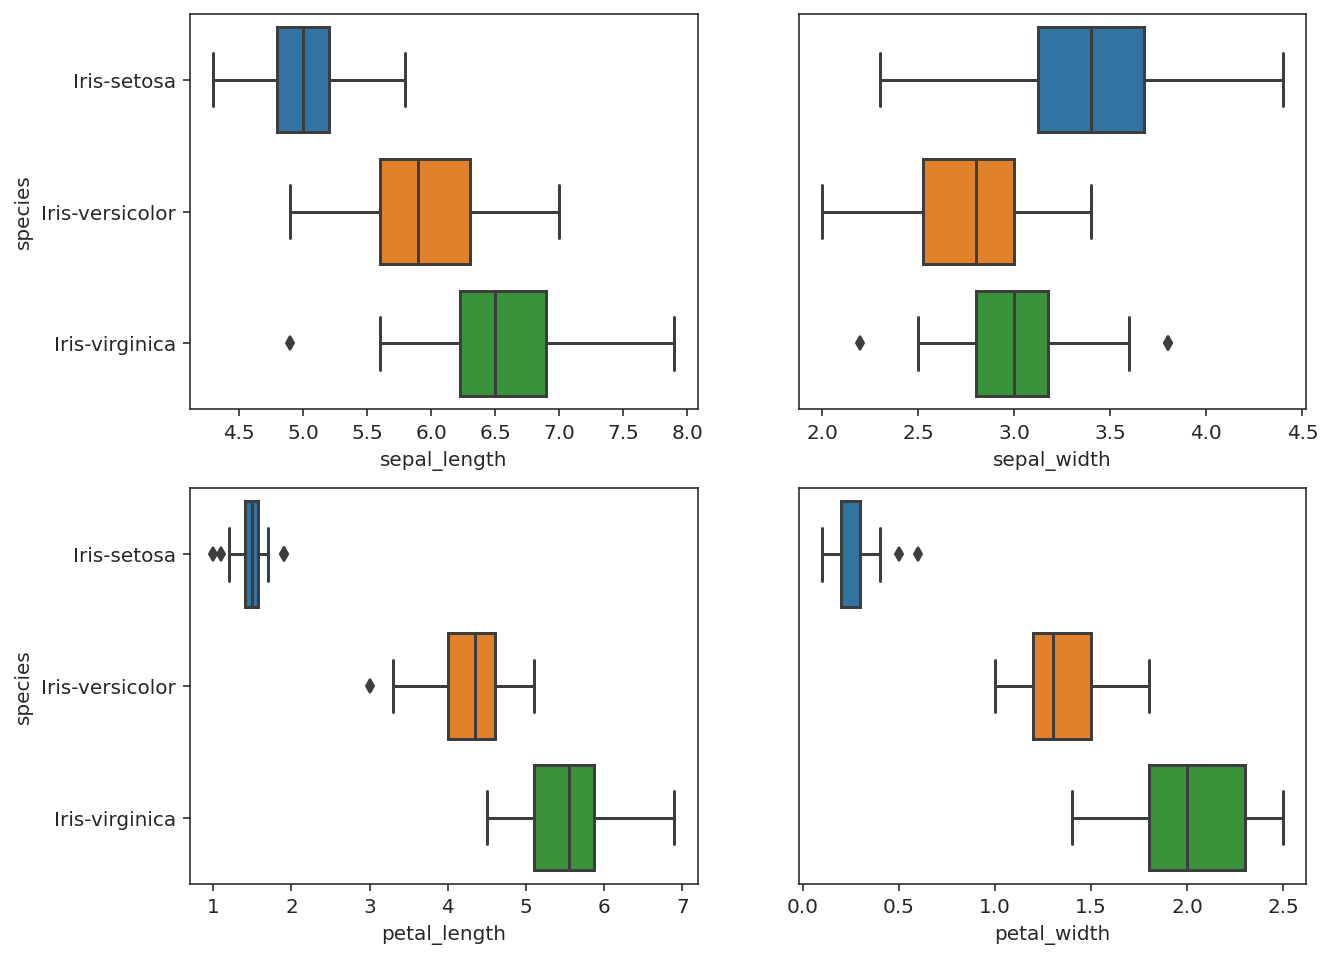

In [ ]:
# Creamos una figura con todos los diagramas de caja
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
# asignamos un gráfico a cada ax
sns.boxplot(x = "sepal_length", y = "species" , data = iris, ax=ax[0,0])
sns.boxplot(x = "sepal_width", y = "species" , data = iris, ax=ax[0,1])
ax[0,1].set(ylabel='', yticks =[])
sns.boxplot(x = "petal_length", y = "species" , data = iris, ax=ax[1,0])
sns.boxplot(x = "petal_width", y = "species" , data = iris, ax=ax[1,1])
ax[1,1].set(ylabel='', yticks =[])
plt.show()

A la vista del análisis descriptivo podemos concluir que las variables de longitud y anchura del pétalo nos permiten diferenciar las iris-setosa del resto. También podemos ver que no hay una clara distinción entre las iris versicolor e iris virginicia para ninguna de las predictoras.

### División de muestras

Procedemos con la división de muestras para el entrenamiento del modelo

In [ ]:
# División de muestras estandarizadas
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris_std, y_iris, test_size=0.20, random_state=0)

### Modelo inicial

Comenzamos con el entrenamiento del modelo con las opciones por defecto, es decir, utilizamos la penalización `l2`.

In [ ]:
# Modelo de regresión logística multinomial datos iris
modelo_iris = LogisticRegression(multi_class='multinomial', solver='lbfgs', 
                                   random_state= 42).fit(X_train_iris, y_train_iris)

Obtenemos los coeficientes del modelo así como la ecuación del modelo para cada una de las especies.

In [ ]:
# Interceptación
intercept = pd.DataFrame(np.round(modelo_iris.intercept_,2))
# Coeficientes del modelo
coef = pd.DataFrame(np.round(modelo_iris.coef_,2))
# matriz de coeficientes
coefs_modelo = pd.concat([intercept, coef], axis=1)   
# cambiamos el nombre de las filas y las columnas
columnas = ['incercept', 'sepal_length', 'sepal_width',	'petal_length',	'petal_width']
filas = modelo_iris.classes_
coefs_modelo = coefs_modelo.set_axis(filas, axis=0).set_axis(columnas, axis=1)
coefs_modelo

,incercept,sepal_length,sepal_width,petal_length,petal_width
Iris-setosa,-0.30,-0.99,1.04,-1.8,-1.71
Iris-versicolor,1.85,0.46,-0.37,-0.2,-0.74
Iris-virginica,-1.56,0.53,-0.67,2.0,2.45


El modelo obtenido viene dado por las ecuaciones siguientes: 

$$\widehat{species}_{iris-setosa} = - 0.3 - 0.99(sepal-length) + 1.04(sepal-width) - 1.8(petal-length) -1.71(petal-width)$$
$$\widehat{species}_{iris-versicolor} = 1.85 + 0.46(sepal-length) - 0.37(sepal-width) - 0.2(petal-length) -0.74(petal-width)$$
$$\widehat{species}_{iris-virginica} = -1.56 + 0.53(sepal-length) - 0.67(sepal-width) + 2(petal-length) + 2.45(petal-width)$$

Las mayores diferencias que se observan en los coeficientes para cada una de las especies van asociadas con las variables `petal_lenth` y `petal_width`, como era de esperar a la vista de la inspección gráfica de los datos. Estas variables son las que ayudarán más a la hora de clasificar cada elemento de la muestra de validación en una clase distinta. En el gráfico siguiente podemos ver la diferencia entre los coeficientes para cada especie. Aquí queda más claro qué variables son más relevantes en la clasificación. Los puntos cercanos para un mismo coeficiente indican poco poder de clasificación mientras que puntos separados indican gran poder de clasificación.

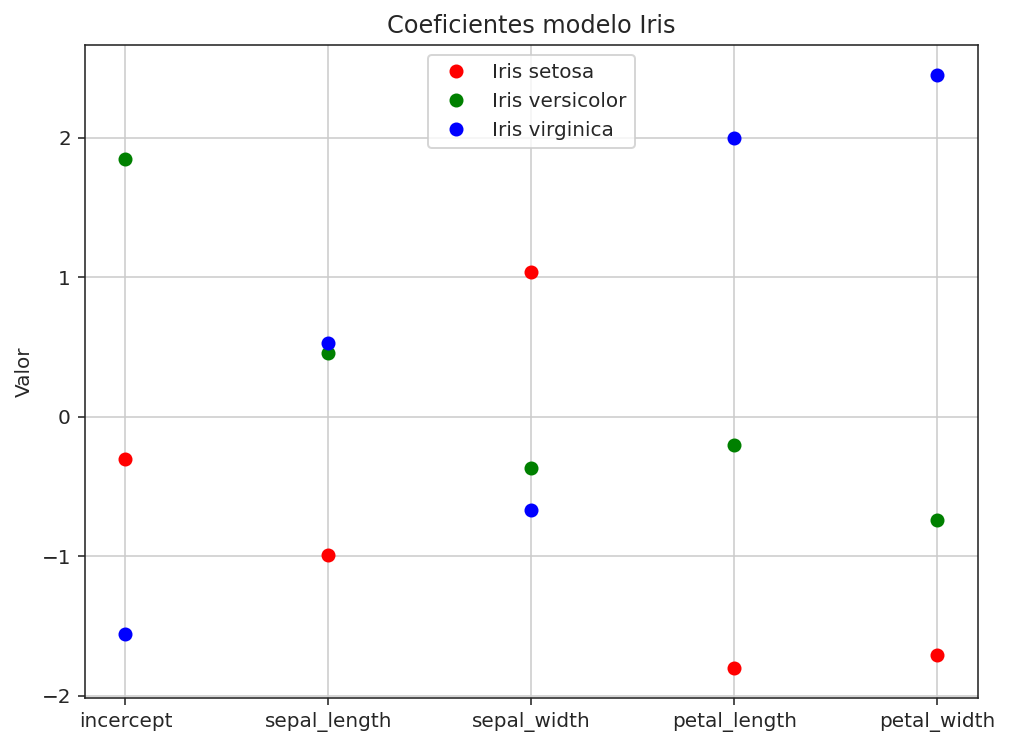

In [ ]:
# Gráfico de los coeficientes del modelo
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.plot(coefs_modelo.T['Iris-setosa'], color = 'red', marker='o',linewidth=0, label = 'Iris setosa')
ax.plot(coefs_modelo.T['Iris-versicolor'], color = 'green', marker='o',linewidth=0, label = 'Iris versicolor')
ax.plot(coefs_modelo.T['Iris-virginica'], color = 'blue', marker='o',linewidth=0, label = 'Iris virginica')
ax.grid()
plt.ylabel('Valor')
plt.legend(loc='upper center')
plt.title('Coeficientes modelo Iris')
plt.show()

Dado que en este caos la respuesta es de tipo categórico no podemos intrepretar los odds asociados con los parámetros del modelo, ya que tenemos una ecuación por cada tipo de la respuesta. Para poder comparar el efecto que cada predictora tiene en la probabilidad de clasificación de cada tipo de flor es necesario definir los odds ratios de comparación entre pares de especies como:

$$odds = \frac{exp(\beta_1)}{exp(\beta_2)} = exp(\beta_1 -\beta_2),$$

$$odds = \frac{exp(\beta_1)}{exp(\beta_3)}= exp(\beta_1 -\beta_3),$$

$$odds = \frac{exp(\beta_2)}{exp(\beta_2)}= exp(\beta_2 -\beta_3),$$

donde $\beta_1$, $\beta_2$, y $\beta_3$ son los coeficientes asociados con una variable en particular en las clase 1, 2 y 3. En este sentido se pueden interpretar los odds ratio de la forma siguiente:

* Cuando el odds ratio es igual a uno las dos clases son igualmente probables.
* Cuando el odds ratio es menor a uno la clase que se sitúa en el denominador es más probable que la del numerador.
* Cuando el odds ratio es mayor a uno la clase que se sitúa en el numerador es más probable que la del denominador.

En el código siguiente se extraen dichos odds ratios a partir de la matriz de coeficientes anterior.

In [ ]:
# número de clases
ncl = len(modelo_iris.classes_)
indice = ['Setosa - Versicolor', 'Setosa - Virginica', 'Versicolor - Virginica']
# Calculamos ratios
odds_ratio = pd.DataFrame()
odds_ratio = odds_ratio.append(np.exp(coefs_modelo.iloc[0,:])/np.exp(coefs_modelo.iloc[1,:]),ignore_index=True)
odds_ratio = odds_ratio.append(np.exp(coefs_modelo.iloc[0,:])/np.exp(coefs_modelo.iloc[2,:]),ignore_index=True)
odds_ratio = odds_ratio.append(np.exp(coefs_modelo.iloc[1,:])/np.exp(coefs_modelo.iloc[2,:]),ignore_index=True)
odds_ratio['Indice'] = indice
# Matriz de resultados
ns = coefs_modelo.shape[1]+1
odds_ratio = odds_ratio.iloc[:,1:ns].set_index("Indice")
odds_ratio

,sepal_length,sepal_width,petal_length,petal_width
Indice,,,,
Setosa - Versicolor,0.234570,4.095955,0.201897,0.379083
Setosa - Virginica,0.218712,5.528961,0.022371,0.015608
Versicolor - Virginica,0.932394,1.349859,0.110803,0.041172


Analizamos con detalle la variable `petal_width`. 

* En la comparación entre Setosa y Vesicolor podemos ver que el aumento de la variable `petal_width` favorece más a la clase Versicolor. De hecho, al aumentar esa variable es 2.6 (1/0.38) veces más probable que clasifiquemos la flor como Versicolor que como Setosa.
* En la comparación entre Setosa y Virginica podemos ver que el aumento de la variable `petal_width` favorece más a la clase Virginica. De hecho, al aumentar esa variable es 50 (1/0.02) veces más probable que clasifiquemos la flor como Virginica que como Setosa.
* En la comparación entre Versicolor y Virginica podemos ver que el aumento de la variable `petal_width` favorece más a la clase Virginica. De hecho, al aumentar esa variable es 25 (1/0.04) veces más probable que clasifiquemos la flor como Virginica que como Versicolor.

Esta variable parece proporcionar una buena discriminación entre las tres especies estableciendo el orden Setosa < Versicolor < Virginica con los valores de dicha variable, de forma que valores pequeños nos sitúan sobre la clase Setosa, y valores altos sobre Viginica. Esta información es compatible con el análisis descriptivo gráfico que se hizo anteriormente. Podemos preceder de forma similar con el resto de predictoras.

Realizamos la representación gráfica de los odds ratios para todas las variables.

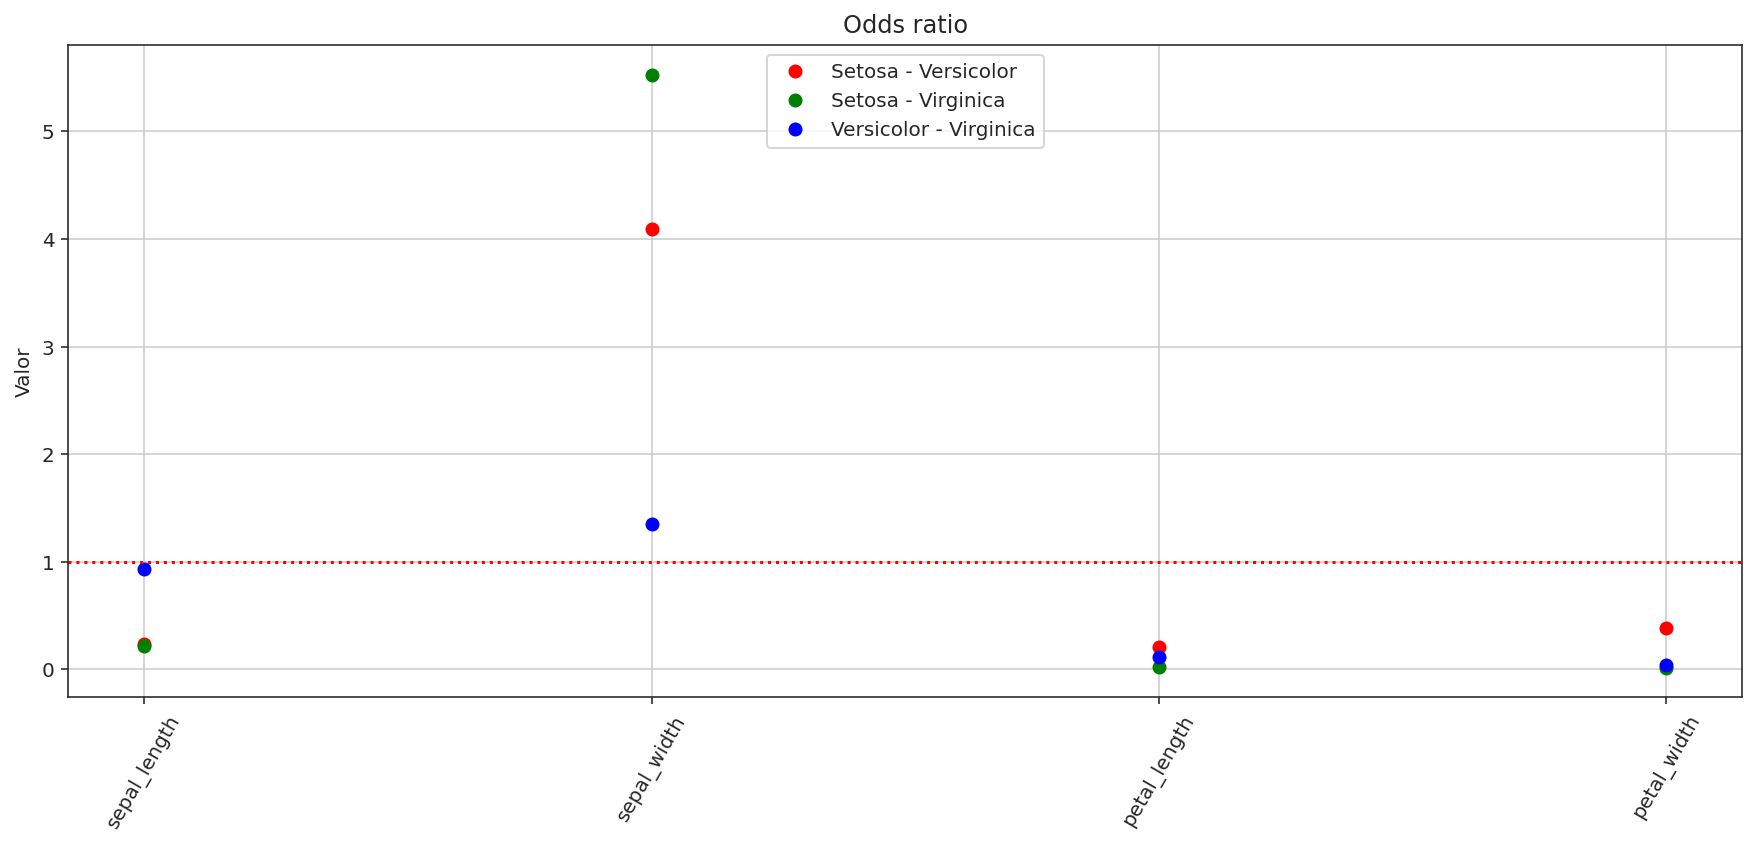

In [ ]:
# Gráfico de odds ratios
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
ax.plot(odds_ratio.T["Setosa - Versicolor"], color = 'red', marker='o',linewidth=0, label = 'Setosa - Versicolor')
ax.plot(odds_ratio.T["Setosa - Virginica"], color = 'green', marker='o',linewidth=0, label = 'Setosa - Virginica')
ax.plot(odds_ratio.T["Versicolor - Virginica"], color = 'blue', marker='o',linewidth=0, label = 'Versicolor - Virginica')
ax.grid()
ax.tick_params(axis='x', rotation=60)
plt.axhline(y = 1, color = 'r', linestyle = 'dotted')
plt.ylabel('Valor')
plt.legend(loc='upper center')
plt.title('Odds ratio')
plt.show()

Estudiamos ahora las métricas de validación del modelo para lo que en primer lugar debemos obtener las predicciones tanto del modelo como de la probabilidad de clasificación en cada una de las clases de interés.

In [ ]:
# Predicción de la muestra de validación
preds_iris = modelo_iris.predict(X_test_iris)
# Predicción de la probabilidad de clasificación
preds_iris_probs = modelo_iris.predict_proba(X_test_iris)

En primer lugar valoramos la exactitud del modelo entrenado

In [ ]:
accuracy_score(y_test_iris, preds_iris)

1.0

Tenemos una clasificación perfecta, es decir, somos capaces de clasificar correctamente todas las muestras de validación. Veamos la matriz de confusión:

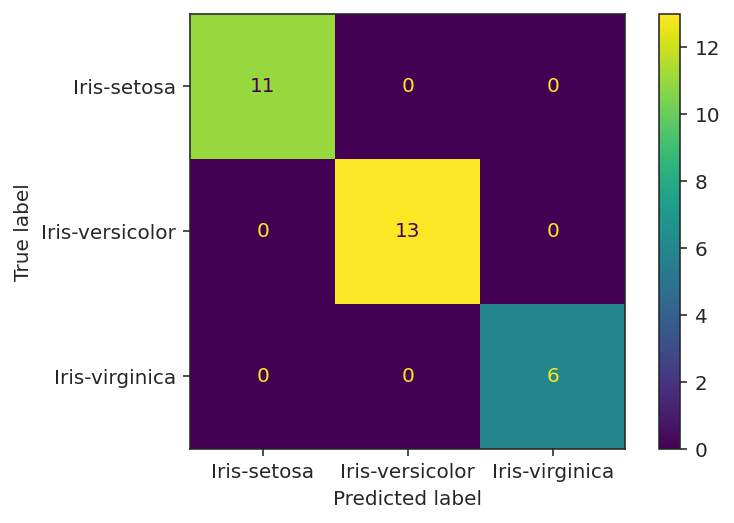

In [ ]:
# Matriz de confusión 
cm_iris= confusion_matrix(y_test_iris, preds_iris, labels = modelo_iris.classes_)
# Solución gráfica
ConfusionMatrixDisplay(confusion_matrix=cm_iris, display_labels=modelo_iris.classes_).plot();

### Validación del modelo

Aunque hemos obtenido una clasificación perfecta resulta necesario realizar un proceso de validación para estudiar la estabilidad en la estimación de la exactitud. 

In [ ]:
# Obtenemos los scores de validación
score_val = pd.DataFrame(cross_val_score(modelo_iris, X_train_iris, y_train_iris, cv=10, scoring ='accuracy'), columns=['score'])
# Describios los valores obtenidos
score_val.describe().T

,count,mean,std,min,25%,50%,75%,max
score,10.0,0.95,0.058267,0.833333,0.916667,0.958333,1.0,1.0


El valor medio de exactitud para las diez muestras de validación se sitúa en el 95% indicando que el modelo entrenado permite clasificar casi de forma perfecta.

Analizamos ahora la curva de aprendizaje conforme variamos el tamaño de la muestra de entrenamiento y validación.

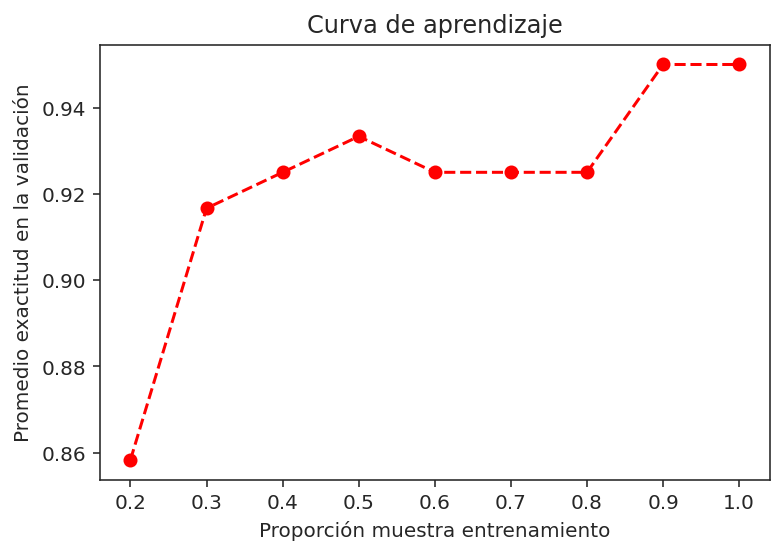

In [ ]:
#Fijamos tamaños de muestra de entrenamiento
size = np.linspace(0.2, 1, 9)
# Evalaumos la precisión para los diferentes tamaños
train_sizes, train_scores, test_scores = learning_curve(
    modelo_iris, X_train_iris, y_train_iris, train_sizes=size, scoring="accuracy", cv=10)
# Representamos gráficamente
plt.plot(size, test_scores.mean(1), "o--", color="r", label="Validación")
plt.xlabel("Proporción muestra entrenamiento")
plt.ylabel("Promedio exactitud en la validación")
plt.title("Curva de aprendizaje")
plt.show()

Se puede ver como a partir del 30% de muestras de entrenamiento la exactitud no baja del 90% indicando una gran estabilidad en todos los aspectos. Dado que el modelo presenta unos resultados tan espectaculares no parece necesario modificar el algoritmo propuesto modificando las condiciones iniciales para su ajuste.

## <font color="steelblue">Abalone</font>

### Preprocesamiento y análisis exploratorio

Como en el ejemplo anterior determinamos los tipos de las variables que componen el banco de datos.

In [ ]:
abalone.dtypes

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
Rings               int64
dtype: object

Separamos en matriz de predictoras y respuesta. Modificamos el tipo de la variable `species` y estandarizamos las variables de tipo numérico.

In [ ]:
# Preparamos datos
X_abalone = abalone.drop(columns='Sex')
y_abalone = abalone['Sex'].astype('category')
# Estandarizamos datos
sc = StandardScaler()
X_abalone_std = sc.fit_transform(X_abalone)

Pasamos al análisis exploratorio del banco de datos. En concreto vemos como se relaciona cada una de las predictoras con la respuesta. Obtenemos la tabla de medias y desviaciones típicas por cada categoría de la variable `Sex`.

In [ ]:
# Análisis exploratorio
abalone.groupby("Sex").agg(['count', 'mean', 'std']).reset_index()

Sex Length                     Diameter                     Height  \
       count      mean       std    count      mean       std  count   
0   F   1307  0.579093  0.086160     1307  0.454732  0.070954   1307   
1   I   1342  0.427746  0.108858     1342  0.326494  0.088109   1342   
2   M   1528  0.561391  0.102697     1528  0.439287  0.084398   1528   

                       ... Shucked weight Viscera weight                      \
       mean       std  ...            std          count      mean       std   
0  0.158011  0.039984  ...       0.198663           1307  0.230689  0.097617   
1  0.107996  0.031995  ...       0.128405           1342  0.092010  0.062536   
2  0.151381  0.034804  ...       0.223000           1528  0.215545  0.104919   

  Shell weight                     Rings                       
         count      mean       std count       mean       std  
0         1307  0.302010  0.125649  1307  11.129304  3.104256  
1         1342  0.128182  0.084927  1342   7.890462  2.511554  
2         1528  0.281969  0.130834  1528  10.705497  3.026349  

[3 rows x 25 columns]

Veamos los diagramas de caja asociados

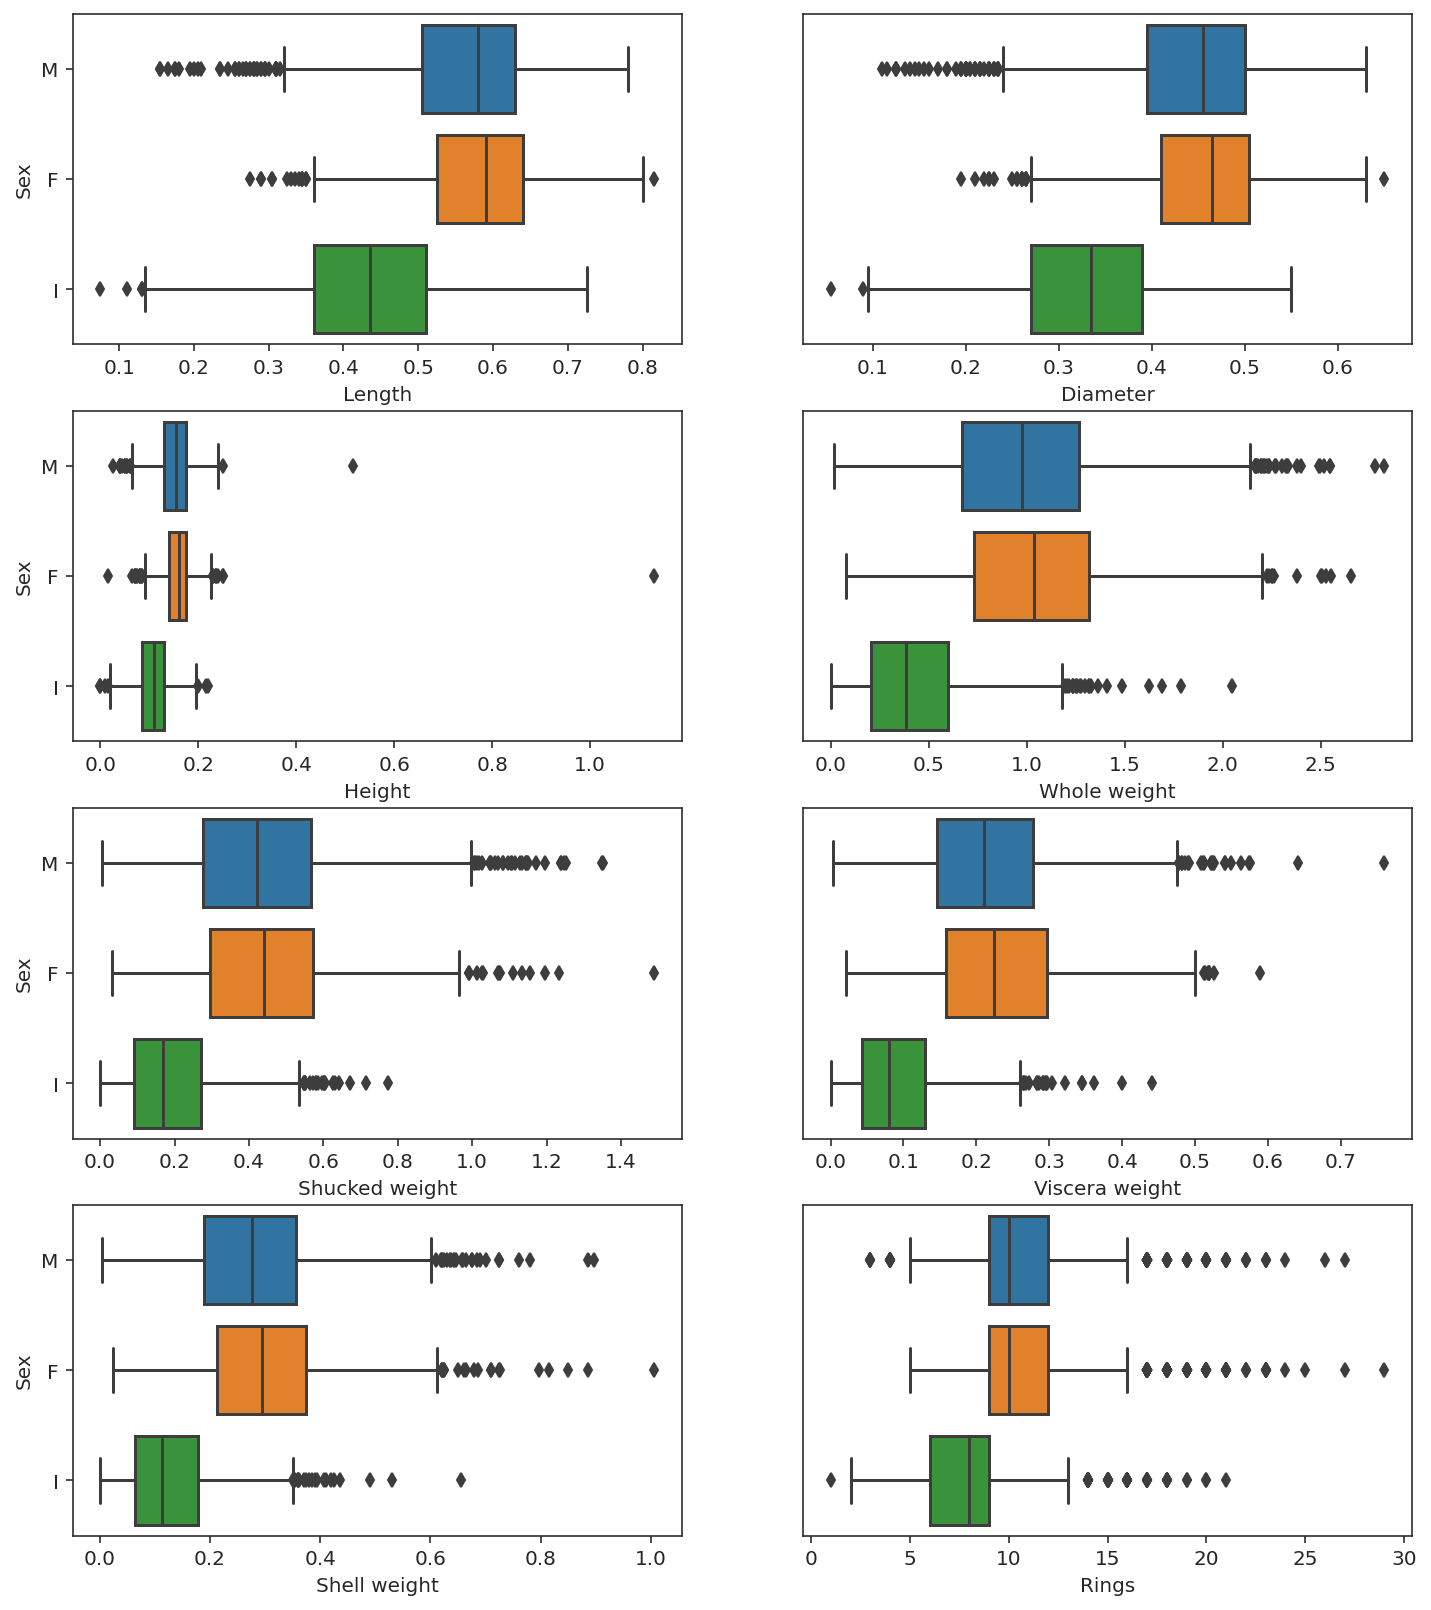

In [ ]:
# Creamos una figura con todos los diagrmas de caja
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12, 14))
# asignamos un gráfico a cada ax
sns.boxplot(x = "Length", y = "Sex" , data = abalone, ax=ax[0,0])
sns.boxplot(x = "Diameter", y = "Sex" , data = abalone, ax=ax[0,1])
ax[0,1].set(ylabel='', yticks =[])
sns.boxplot(x = "Height", y = "Sex" , data = abalone, ax=ax[1,0])
sns.boxplot(x = "Whole weight", y = "Sex" , data = abalone, ax=ax[1,1])
ax[1,1].set(ylabel='', yticks =[])
sns.boxplot(x = "Shucked weight", y = "Sex" , data = abalone, ax=ax[2,0])
sns.boxplot(x = "Viscera weight", y = "Sex" , data = abalone, ax=ax[2,1])
ax[2,1].set(ylabel='', yticks =[])
sns.boxplot(x = "Shell weight", y = "Sex" , data = abalone, ax=ax[3,0])
sns.boxplot(x = "Rings", y = "Sex" , data = abalone, ax=ax[3,1])
ax[3,1].set(ylabel='', yticks =[])
plt.show()

En este caso no se aprecia que ninguna de las predictoras sea capaz de discriminar o clasificar de forma efectiva en relación a la variable sexo.

### División de muestras


La variable a la que le asignamos la $y$ es `Sex` y a las variables predictoras les asignamos la $X$.

In [ ]:
# División de muestras estandarizadas
X_train_abalone, X_test_abalone, y_train_abalone, y_test_abalone = train_test_split(X_abalone_std, y_abalone, test_size=0.20, random_state=0)

### Modelo inicial

Ajustamos el modelo inicial

In [ ]:
# Modelo de regresión logística multinomial datos iris
modelo_abalone = LogisticRegression(multi_class='multinomial', solver='lbfgs', 
                                   random_state= 42).fit(X_train_abalone, y_train_abalone)

Obtenemos los coeficientes del modelo así como la ecuación del modelo para cada una de los niveles de sexo.

In [ ]:
# Interceptación
intercept = pd.DataFrame(np.round(modelo_abalone.intercept_,2))
# Coeficientes del modelo
coef = pd.DataFrame(np.round(modelo_abalone.coef_,2))
# matriz de coeficientes
coefs_modelo = pd.concat([intercept, coef], axis=1)   
# cambiamos el nombre de las filas y las columnas
columnas = ['incercept', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
filas = modelo_abalone.classes_
coefs_modelo = coefs_modelo.set_axis(filas, axis=0).set_axis(columnas, axis=1)
coefs_modelo

,incercept,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
F,0.17,-0.62,0.52,0.18,0.66,-0.44,0.67,-0.15,0.21
I,-0.61,1.20,-0.43,-0.25,-1.33,0.27,-1.04,0.24,-0.44
M,0.45,-0.58,-0.09,0.06,0.68,0.16,0.37,-0.08,0.23


El modelo obtenido viene dado por:

$$\widehat{Sex}_{M} = 0.17 - 0.62Length + 0.52Diameter + 0.18Height + 0.66Whole weight -0.44Stucked weight+0.67Viscera weight -0.15Shell weight +0.21Rings$$
$$\widehat{Sex}_{F} = -0.61 + 1.2Length -0.43Diameter - 0.25Height -1.33Whole weight+ 0.27Stucked weight- 1.04Viscera weight +0.24Shell weight -0.44Rings$$
$$\widehat{Sex}_{I} = 0.45 - 0.58Length - 0.09Diameter + 0.06Height + 0.68Whole weight +0.16Stucked weight +0.37Viscera weight -0.08Shell weight +0.23Rings$$

Como  era de esperar tras la visualización gráfica no se aprecian grandes diferencias entre los coeficientes asignados a una misma variable para los diferentes niveles de `Sex`. Como en el ejemplo anterior representamos los coeficientes del modelo. 

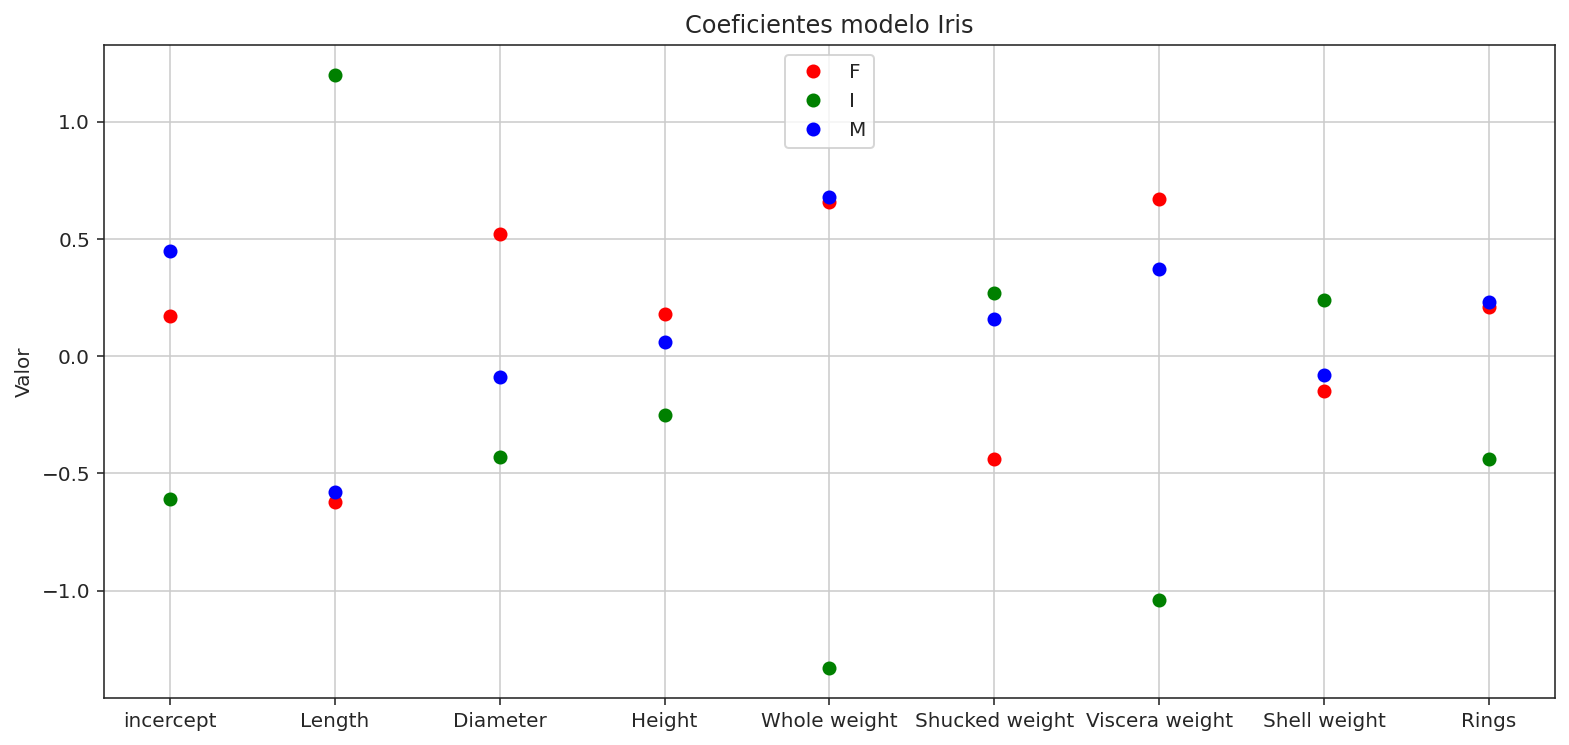

In [ ]:
# Gráfico de los coeficientes del modelo
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 6))
ax.plot(coefs_modelo.T['F'], color = 'red', marker='o',linewidth=0, label = 'F')
ax.plot(coefs_modelo.T['I'], color = 'green', marker='o',linewidth=0, label = 'I')
ax.plot(coefs_modelo.T['M'], color = 'blue', marker='o',linewidth=0, label = 'M')
ax.grid()
plt.ylabel('Valor')
plt.legend(loc='upper center')
plt.title('Coeficientes modelo Iris')
plt.show()

En este caso los valores de los coeficientes se encuentran muy próximos y sólo se observan pequeñas diferencias en `Length`, `Whole weight`, y `Viscera weight` entre individuos adultos frente a individuos infantiles. Los individuos adultos tienen prácticamente el mismo comportamiento lo que hará difícil que el algoritmo clasifique correctamente. Analizamos los odds ratios asociados a los diferentes niveles de `sex`.

In [ ]:
# número de clases
ncl = len(modelo_abalone.classes_)
indice = ['M - F', 'M - I', 'F - I']
# Calculamos ratios
odds_ratio = pd.DataFrame()
odds_ratio = odds_ratio.append(np.exp(coefs_modelo.iloc[0,:])/np.exp(coefs_modelo.iloc[1,:]),ignore_index=True)
odds_ratio = odds_ratio.append(np.exp(coefs_modelo.iloc[0,:])/np.exp(coefs_modelo.iloc[2,:]),ignore_index=True)
odds_ratio = odds_ratio.append(np.exp(coefs_modelo.iloc[1,:])/np.exp(coefs_modelo.iloc[2,:]),ignore_index=True)
odds_ratio['Indice'] = indice
# Matriz de resultados
ns = coefs_modelo.shape[1]+1
odds_ratio = odds_ratio.iloc[:,1:ns].set_index("Indice")
odds_ratio

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
Indice,,,,,,,,
M - F,0.162026,2.585710,1.537258,7.315534,0.491644,5.528961,0.677057,1.915541
M - I,0.960789,1.840431,1.127497,0.980199,0.548812,1.349859,0.932394,0.980199
F - I,5.929856,0.711770,0.733447,0.133989,1.116278,0.244143,1.377128,0.511709


Si analizamos el comportamiento de la varaible `length` podemos concluir que:

* En la comparación entre M y F podemos ver que el aumento de la variable `Length` favorece más a la clase F. De hecho, al aumentar esa variable es 6.25 (1/0.16) veces más probable que clasifiquemos el sujeto como F que como M.
* En la comparación entre M e I podemos ver que el aumento de la variable `Length` favorece más a la clase I. De hecho, al aumentar esa variable es 1.04 (1/0.96) veces más probable que clasifiquemos el sujeto como I que como M.
* En la comparación entre F e I podemos ver que el aumento de la variable `Length` favorece más a la clase F. De hecho, al aumentar esa variable es 5.92 veces más probable que clasifiquemos el sujeto como F que como I.

En este caso el orden de los niveles de la respuesta según esta variable viene dado por I < M < F.

Representamos todos los odds ratio para realizar las comparaciones en todas las variables.

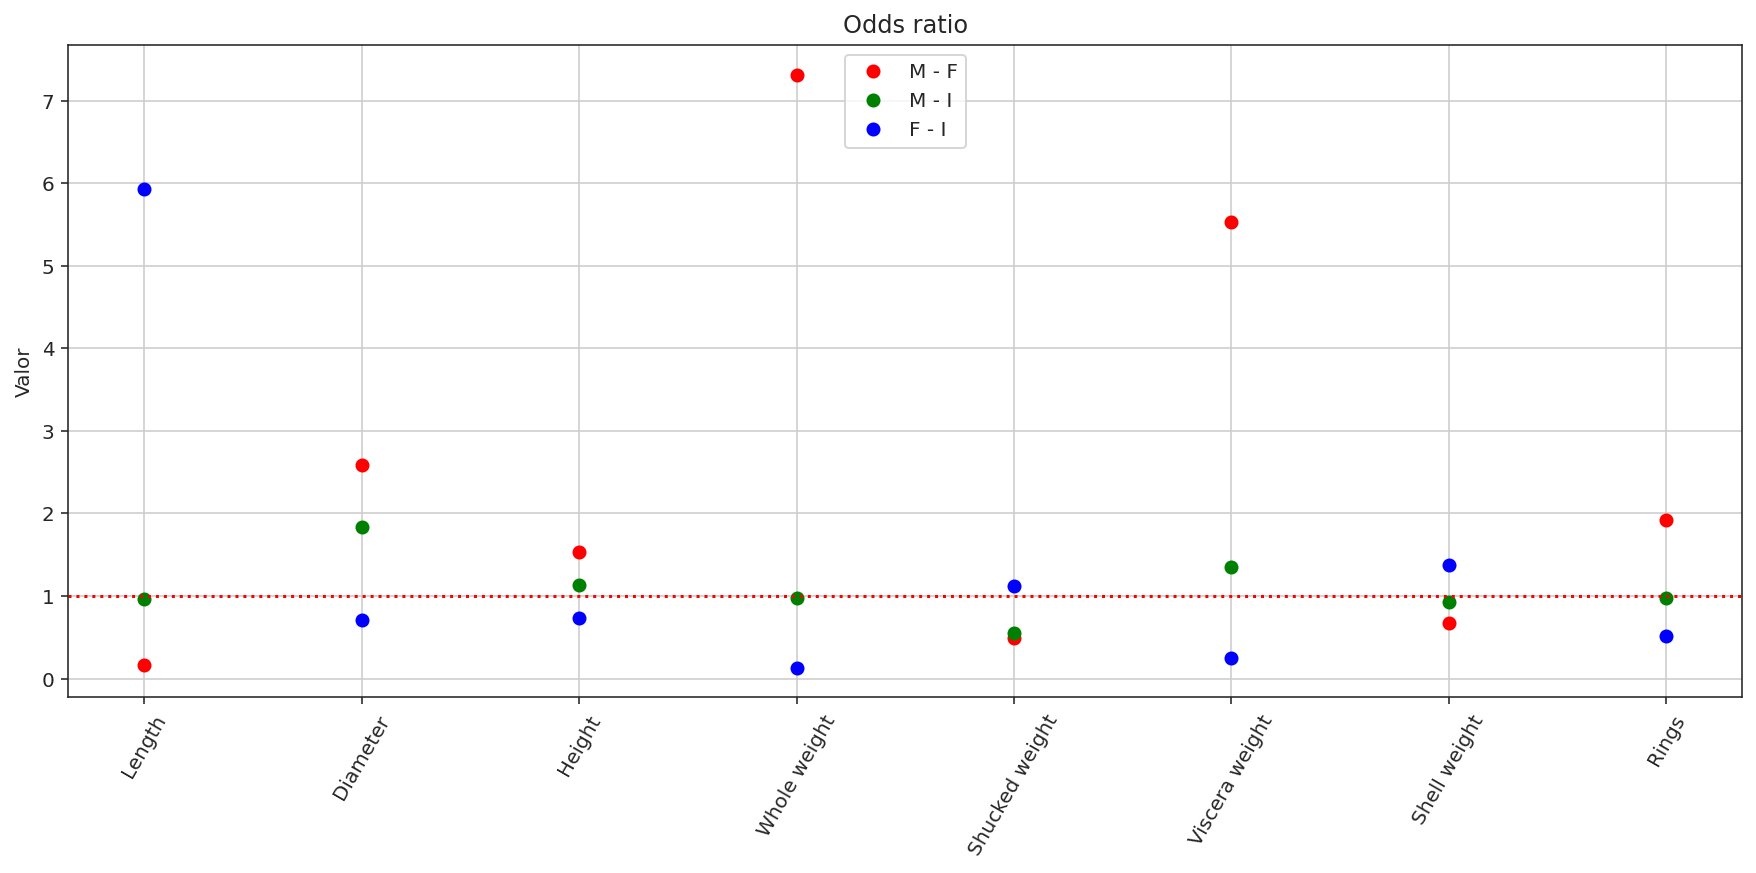

In [ ]:
# Gráfico de los odds ratio
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
ax.plot(odds_ratio.T["M - F"], color = 'red', marker='o',linewidth=0, label = 'M - F')
ax.plot(odds_ratio.T["M - I"], color = 'green', marker='o',linewidth=0, label = 'M - I')
ax.plot(odds_ratio.T["F - I"], color = 'blue', marker='o',linewidth=0, label = 'F - I')
ax.grid()
ax.tick_params(axis='x', rotation=60)
plt.axhline(y = 1, color = 'r', linestyle = 'dotted')
plt.ylabel('Valor')
plt.legend(loc='upper center')
plt.title('Odds ratio')
plt.show()

Analizamos las métricas de validación del modelo para lo que obtenemos las predicciones de la muestra de validación.



In [ ]:
# Predicción de la muestra de validación
preds_abalone = modelo_abalone.predict(X_test_abalone)
# Predicción de la probabilidad de clasificación
preds_abalone_probs = modelo_abalone.predict_proba(X_test_abalone)

Calculamos la exactitud

In [ ]:
accuracy_score(y_test_abalone, preds_abalone)

0.569377990430622

La exactitud obtenida es muy baja (57%) indicando que el modelo no es muy bueno para clasificar los diferentes tipos niveles de `Sex` en función de las predictoras consideradas. Estudiamos la matriz de confusión:

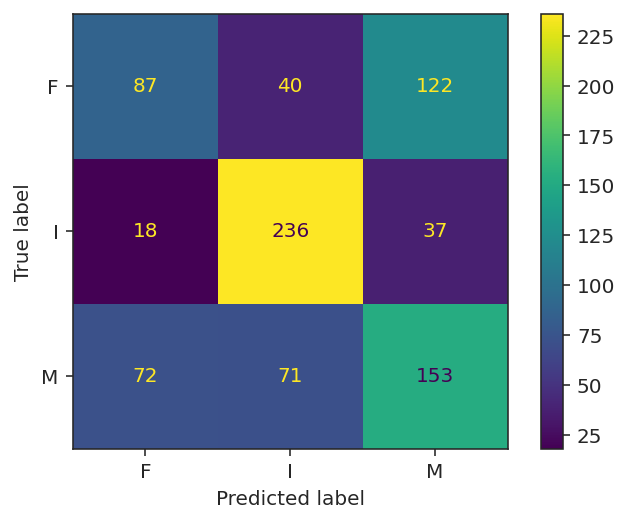

In [ ]:
# Matriz de confusión 
cm_abalone= confusion_matrix(y_test_abalone, preds_abalone, labels = modelo_abalone.classes_)
# Solución gráfica
ConfusionMatrixDisplay(confusion_matrix=cm_abalone, display_labels=modelo_abalone.classes_).plot();

Se han clasificado correctamente 476 de las 836 muestras. Además los errores de clasificación se reparten por igual en todas las clases como podemos ver en el informe completo de clasificación

In [ ]:
# Información de la clasificación modelo 1
print(classification_report(y_test_abalone, preds_abalone))

              precision    recall  f1-score   support

           F       0.49      0.35      0.41       249
           I       0.68      0.81      0.74       291
           M       0.49      0.52      0.50       296

    accuracy                           0.57       836
   macro avg       0.55      0.56      0.55       836
weighted avg       0.56      0.57      0.56       836



La exactitud para machos y hembras se sitúa en el 49%, mientras que sube al 68% para los infantiles. De hecho, para los desarrollados sexualmente nos equivocamos en 1 de cada 2.

Antes de proceder con la validación del modelo vamos a intentar mejorar la exactitud de la clasificación probando diferentes opciones del algoritmo. En concreto probamos las otras dos penalizaciones disponibles. Actualziamos el optimizador y el número de iteraciones.

In [ ]:
# Modelo de regresión logística multinomial datos iris
modelo_abalone_2 = LogisticRegression(multi_class='multinomial', solver='saga', penalty = 'l1', max_iter=1000,
                                   random_state= 42).fit(X_train_abalone, y_train_abalone)
modelo_abalone_3 = LogisticRegression(multi_class='multinomial', solver='saga', penalty = 'elasticnet', l1_ratio=0.5, max_iter=1000,
                                   random_state= 42).fit(X_train_abalone, y_train_abalone)

Obtenemos las predicciones y la exactitud de cada modelo antes de pasar a una evaluación más extensa.

In [ ]:
# Predicción de la muestra de validación
preds_abalone_2 = modelo_abalone_2.predict(X_test_abalone)
preds_abalone_3 = modelo_abalone_3.predict(X_test_abalone)
# Exactitud
print("Penalización l1: ", accuracy_score(y_test_abalone, preds_abalone_2))
print("Penalización elasticnet: ", accuracy_score(y_test_abalone, preds_abalone_3))

Penalización l1:  0.5717703349282297
Penalización elasticnet:  0.5705741626794258


La exactitud es similar en ambos modelos y tambien similar a la obtenida con el modelo por defecto. No se introducen mejoras sustanciales en el modelo de con las nuevas penalizaciones.  Dado el poco poder explicativo del modelo vamos a obviar la parte de validación del modelo.

## <font color="steelblue">Wine recognition</font>

### Preprocesamiento y análisis exploratorio

Identificamos los tipos de las variables

In [ ]:
vinos.dtypes

Class label                       int64
Alcohol                         float64
Malic acid                      float64
Ash                             float64
Alcalinity of ash               float64
Magnesium                         int64
Total phenols                   float64
Flavanoids                      float64
Nonflavanoid phenols            float64
Proanthocyanins                 float64
Color intensity                 float64
Hue                             float64
OD280/OD315 of diluted wines    float64
Proline                           int64
dtype: object

In [ ]:
# Cambiamos el tipo
vinos['Class label'] = vinos['Class label'].astype('category')

Separamos en matriz de predictoras y respuesta. Modificamos el tipo de la variable `Class label` y estandarizamos las variables de tipo numérico.

In [ ]:
# Preparamos datos
X_vinos = vinos.drop(columns='Class label')
y_vinos = vinos['Class label']
# Estandarizamos datos
sc = StandardScaler()
X_vinos_std = sc.fit_transform(X_vinos)

Realizamos el análisis exploratorio de cada predictora con la respuesta. En este caso nos centramos en el análisis gráfico ya que la tabla de resultados es demasiado amplia.

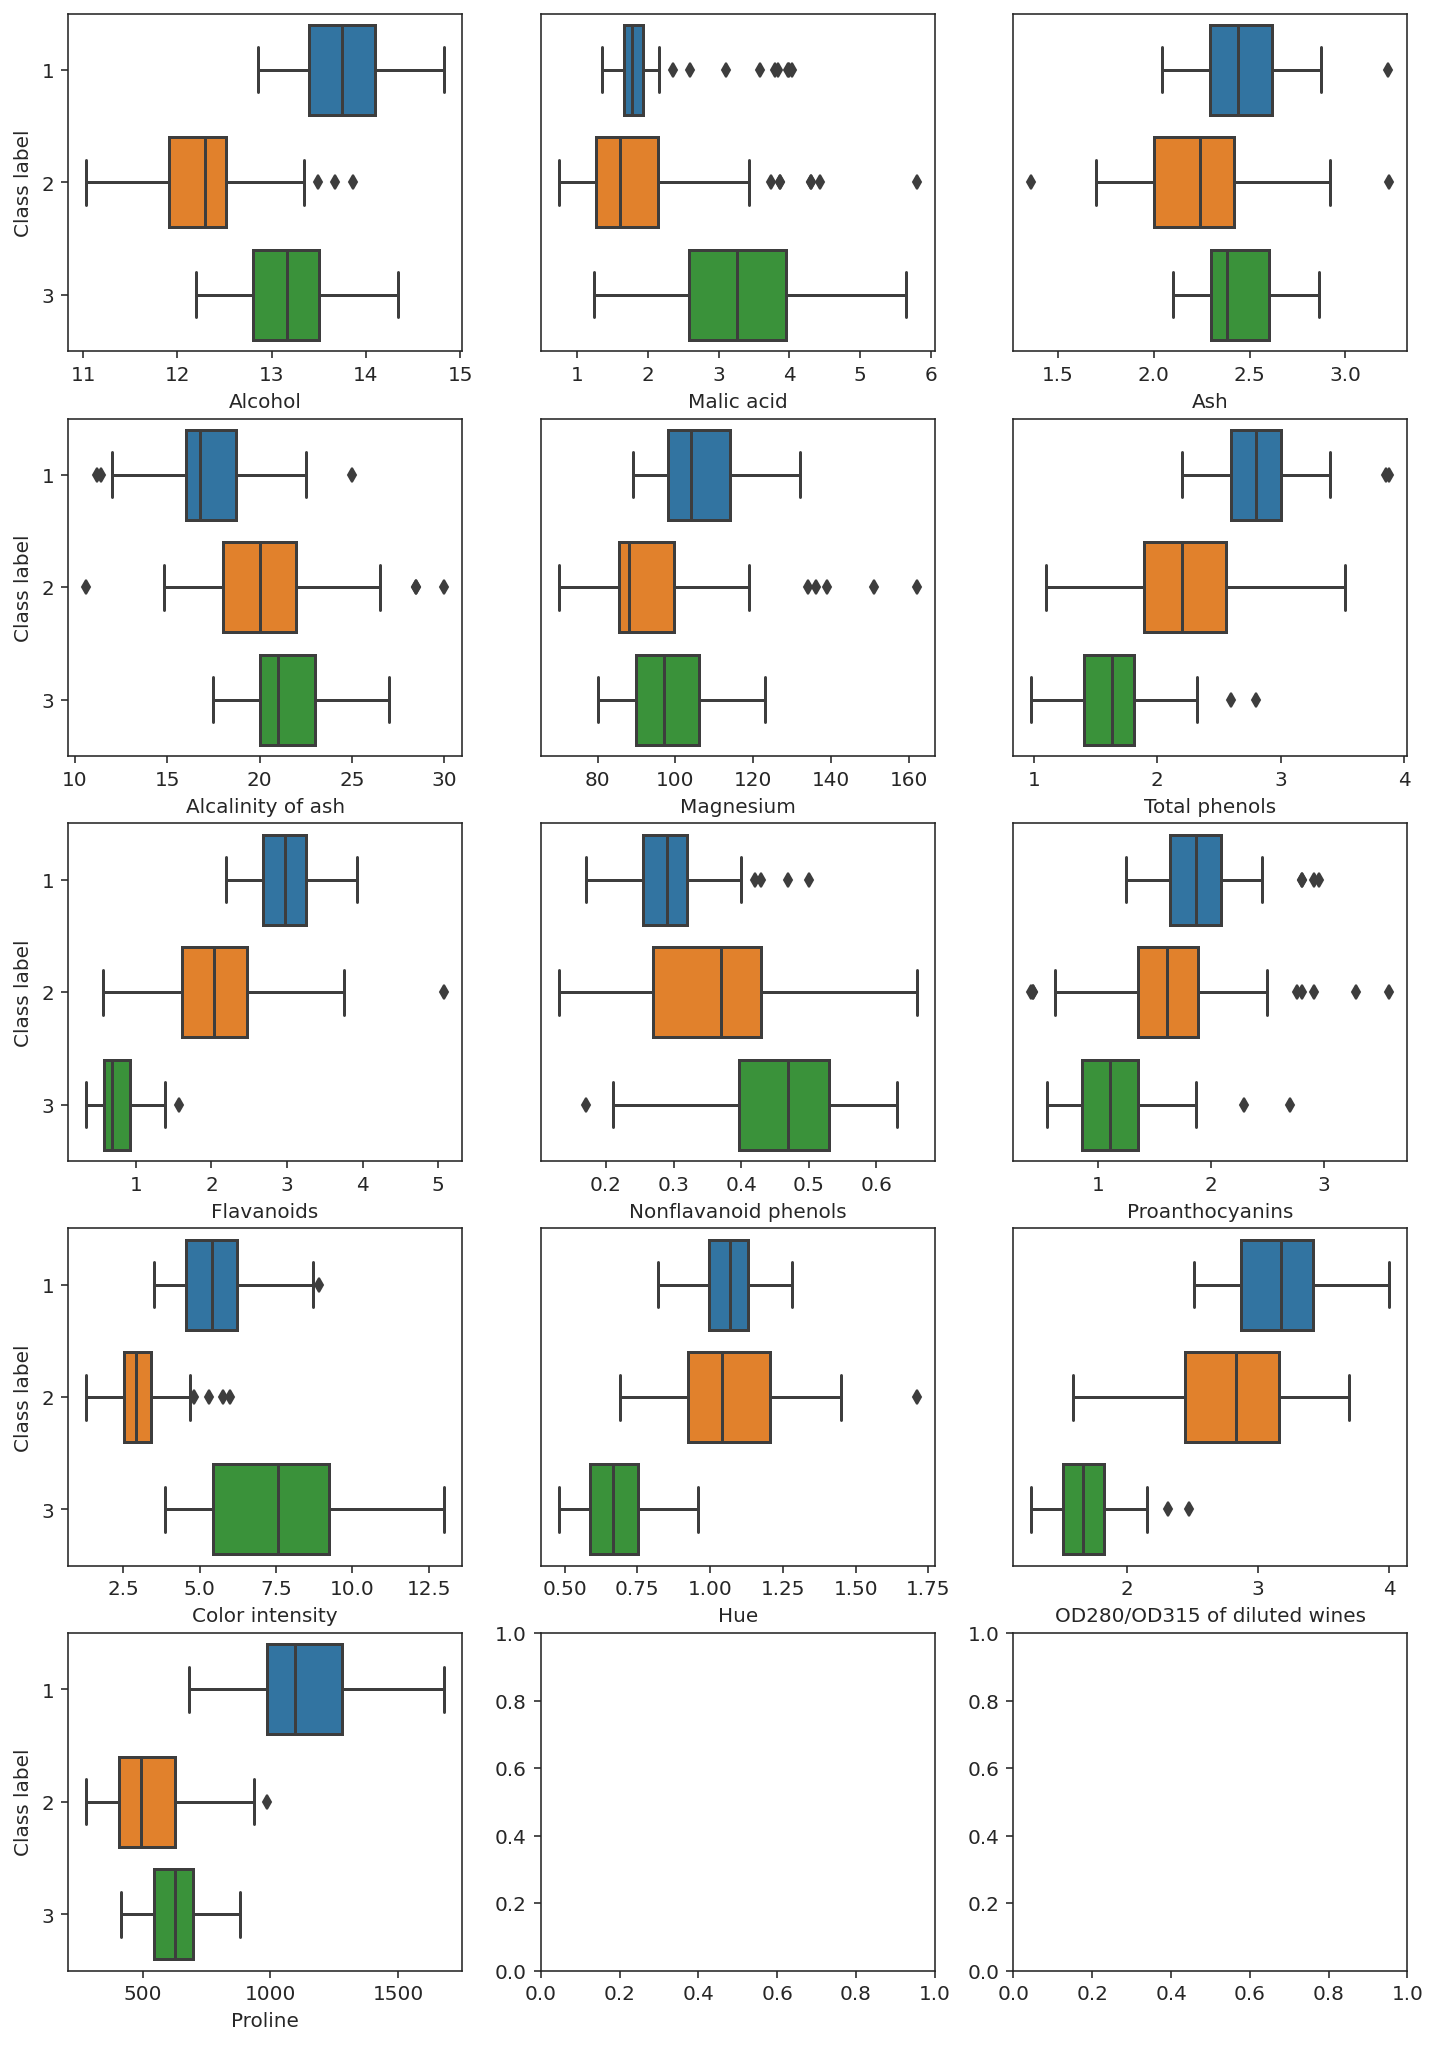

In [ ]:
# Creamos una figura con todos los diagrmas de caja
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(12, 18))
# asignamos un gráfico a cada ax
sns.boxplot(x = "Alcohol", y = "Class label" , data = vinos, ax=ax[0,0])
sns.boxplot(x = "Malic acid", y = "Class label" , data = vinos, ax=ax[0,1])
ax[0,1].set(ylabel='', yticks =[])
sns.boxplot(x = "Ash", y = "Class label" , data = vinos, ax=ax[0,2])
ax[0,2].set(ylabel='', yticks =[])

sns.boxplot(x = "Alcalinity of ash", y = "Class label" , data = vinos, ax=ax[1,0])
sns.boxplot(x = "Magnesium", y = "Class label" , data = vinos, ax=ax[1,1])
ax[1,1].set(ylabel='', yticks =[])
sns.boxplot(x = "Total phenols", y = "Class label" , data = vinos, ax=ax[1,2])
ax[1,2].set(ylabel='', yticks =[])

sns.boxplot(x = "Flavanoids", y = "Class label" , data = vinos, ax=ax[2,0])
sns.boxplot(x = "Nonflavanoid phenols", y = "Class label" , data = vinos, ax=ax[2,1])
ax[2,1].set(ylabel='', yticks =[])
sns.boxplot(x = "Proanthocyanins", y = "Class label" , data = vinos, ax=ax[2,2])
ax[2,2].set(ylabel='', yticks =[])

sns.boxplot(x = "Color intensity", y = "Class label" , data = vinos, ax=ax[3,0])
sns.boxplot(x = "Hue", y = "Class label" , data = vinos, ax=ax[3,1])
ax[3,1].set(ylabel='', yticks =[])
sns.boxplot(x = "OD280/OD315 of diluted wines", y = "Class label" , data = vinos, ax=ax[3,2])
ax[3,2].set(ylabel='', yticks =[])

sns.boxplot(x = "Proline", y = "Class label" , data = vinos, ax=ax[4,0])
plt.show()

### División de muestras

In [ ]:
# División de muestras estandarizadas
X_train_vinos, X_test_vinos, y_train_vinos, y_test_vinos = train_test_split(X_vinos_std, y_vinos, test_size=0.20, random_state=0)

### Modelo inicial

Ajustamos el modelo inicial.

In [ ]:
# Modelo de regresión logística multinomial 
modelo_vinos = LogisticRegression(multi_class='multinomial', solver='lbfgs', 
                                   random_state= 42).fit(X_train_vinos, y_train_vinos)

Obtenemos los coeficientes del modelo y los representamos para cada una de las clases de vino. En este caso obviamos la escritura de los diferentes modelos debido al gran número de predictoras.

In [ ]:
# Interceptación
intercept = pd.DataFrame(np.round(modelo_vinos.intercept_,2))
# Coeficientes del modelo
coef = pd.DataFrame(np.round(modelo_vinos.coef_,2))
# matriz de coeficientes
coefs_modelo = pd.concat([intercept, coef], axis=1)   
# cambiamos el nombre de las filas y las columnas
columnas = ['incercept', 'Alcohol', 'Malic acid', 'Ash', 
'Alcalinity of ash', 'Magnesium', 'Total phenols', 
'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
filas = modelo_vinos.classes_
coefs_modelo = coefs_modelo.set_axis(filas, axis=0).set_axis(columnas, axis=1)
coefs_modelo

,incercept,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
1,0.38,0.73,0.24,0.42,-0.76,-0.01,0.18,0.74,-0.13,0.11,0.17,0.14,0.74,0.99
2,0.65,-0.84,-0.46,-0.76,0.54,-0.09,0.02,0.19,0.13,0.33,-1.08,0.57,0.08,-1.01
3,-1.03,0.11,0.23,0.34,0.22,0.10,-0.20,-0.93,-0.00,-0.44,0.91,-0.71,-0.82,0.02


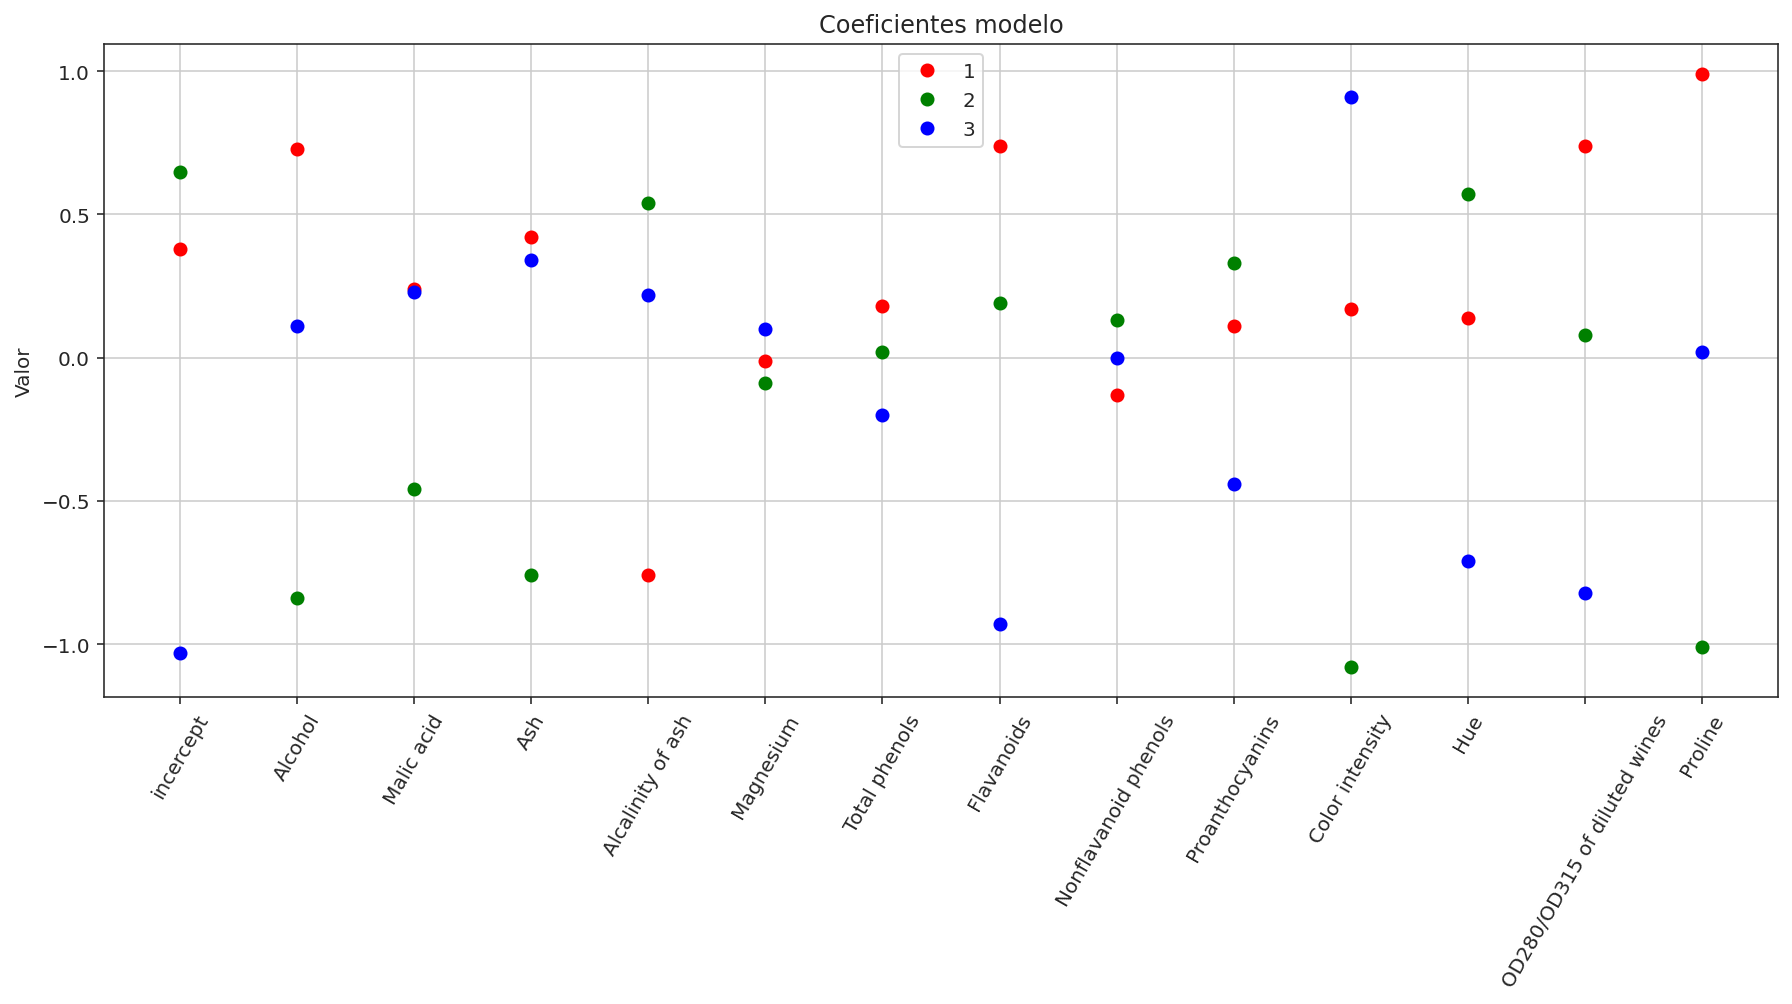

In [ ]:
# Gráfico de los coeficientes del modelo
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
ax.plot(coefs_modelo.T[1], color = 'red', marker='o',linewidth=0, label = '1')
ax.plot(coefs_modelo.T[2], color = 'green', marker='o',linewidth=0, label = '2')
ax.plot(coefs_modelo.T[3], color = 'blue', marker='o',linewidth=0, label = '3')
ax.grid()
ax.tick_params(axis='x', rotation=60)
plt.ylabel('Valor')
plt.legend(loc='upper center')
plt.title('Coeficientes modelo')
plt.show()

Obtenemos los odds ratio asociados con este modelo.

In [ ]:
# número de clases
ncl = len(modelo_abalone.classes_)
indice = ['1 - 2', '1 - 3', '2 - 3']
# Calculamos ratios
odds_ratio = pd.DataFrame()
odds_ratio = odds_ratio.append(np.exp(coefs_modelo.iloc[0,:])/np.exp(coefs_modelo.iloc[1,:]),ignore_index=True)
odds_ratio = odds_ratio.append(np.exp(coefs_modelo.iloc[0,:])/np.exp(coefs_modelo.iloc[2,:]),ignore_index=True)
odds_ratio = odds_ratio.append(np.exp(coefs_modelo.iloc[1,:])/np.exp(coefs_modelo.iloc[2,:]),ignore_index=True)
odds_ratio['Indice'] = indice
# Matriz de resultados
ns = coefs_modelo.shape[1]+1
odds_ratio = odds_ratio.iloc[:,1:ns].set_index("Indice")
odds_ratio

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
Indice,,,,,,,,,,,,,
1 - 2,4.806648,2.013753,3.254374,0.272532,1.083287,1.173511,1.733253,0.771052,0.802519,3.490343,0.650509,1.934792,7.389056
1 - 3,1.858928,1.010050,1.083287,0.375311,0.895834,1.462285,5.312168,0.878095,1.733253,0.477114,2.339647,4.758821,2.637944
2 - 3,0.386741,0.501576,0.332871,1.377128,0.826959,1.246077,3.064854,1.138828,2.159766,0.136695,3.596640,2.459603,0.357007


En este caso representamos gráficamente los odds ratio para realizar una comparación rápida.

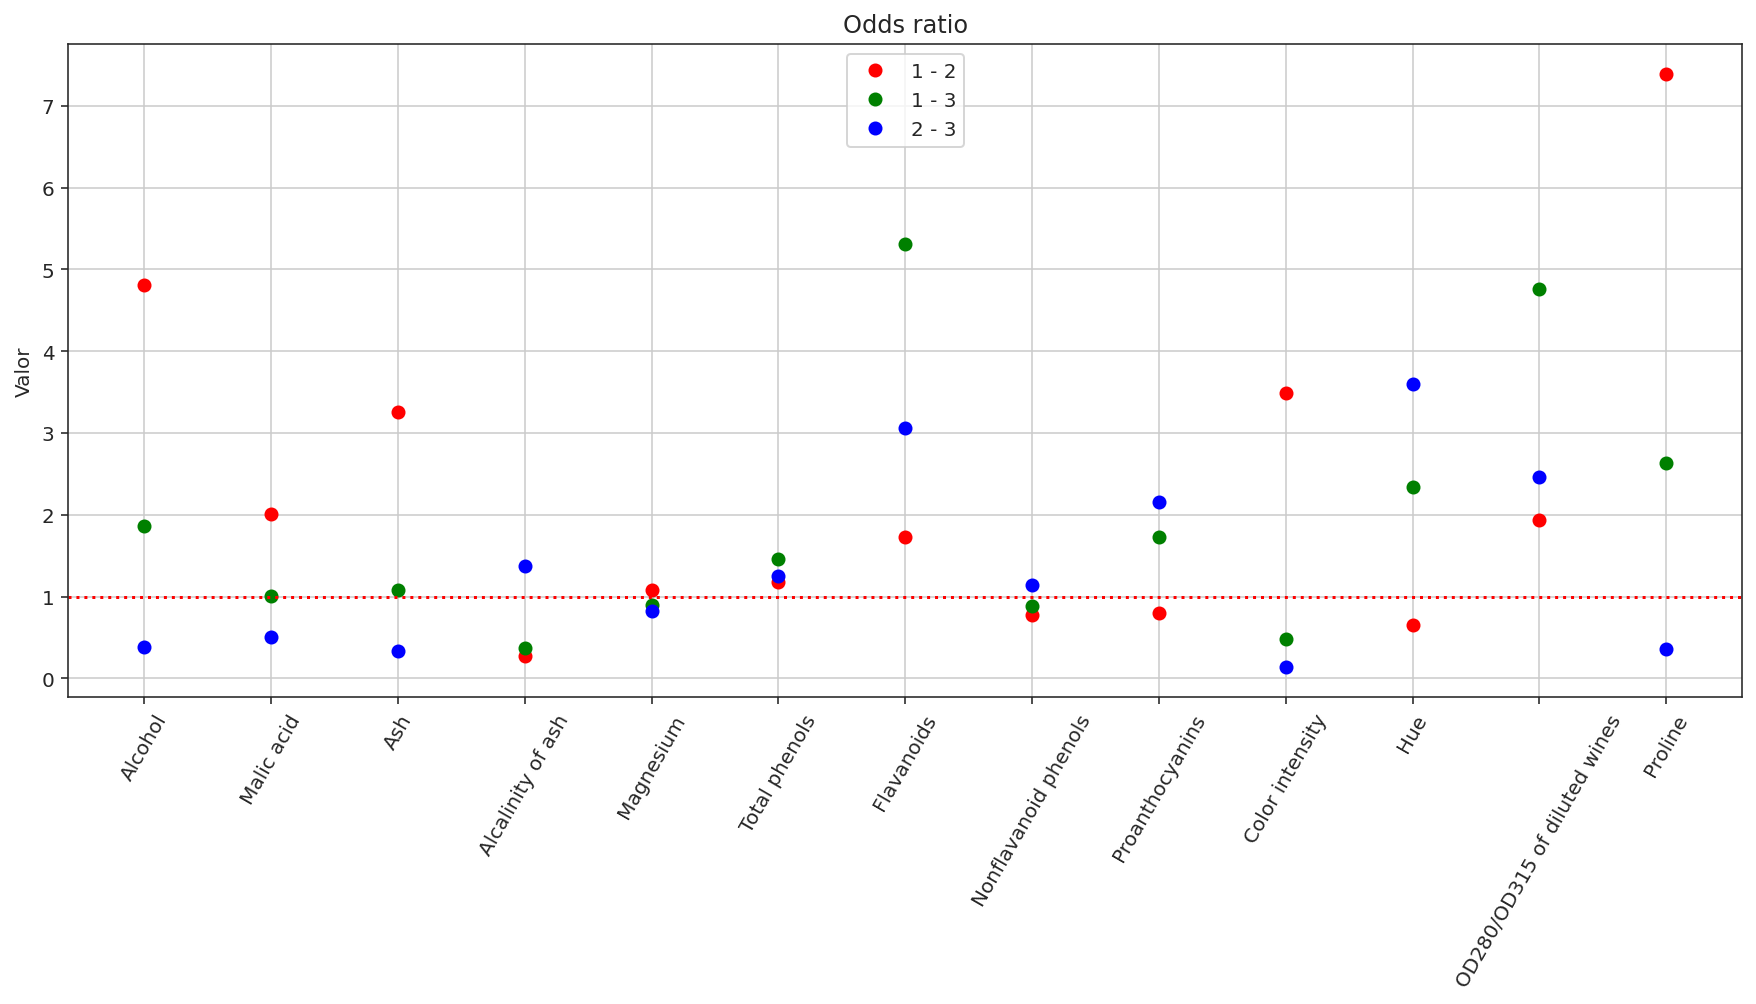

In [ ]:
# Gráfico de los odds ratio
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
ax.plot(odds_ratio.T["1 - 2"], color = 'red', marker='o',linewidth=0, label = '1 - 2')
ax.plot(odds_ratio.T["1 - 3"], color = 'green', marker='o',linewidth=0, label = '1 - 3')
ax.plot(odds_ratio.T["2 - 3"], color = 'blue', marker='o',linewidth=0, label = '2 - 3')
ax.grid()
ax.tick_params(axis='x', rotation=60)
plt.axhline(y = 1, color = 'r', linestyle = 'dotted')
plt.ylabel('Valor')
plt.legend(loc='upper center')
plt.title('Odds ratio')
plt.show()

Analizamos las métricas de validación del modelo para lo que obtenemos las predicciones de la muestra de validación.


In [ ]:
# Predicción de la muestra de validación
preds_vinos = modelo_vinos.predict(X_test_vinos)
# Predicción de la probabilidad de clasificación
preds_vinos_probs = modelo_vinos.predict_proba(X_test_vinos)

Calculamos la exactitud, que nos proporciona la calidad de la clasificación que se ha realizado con el modelo ajustado.

In [ ]:
accuracy_score(y_test_vinos, preds_vinos)

1.0

Tenemos una clasificación perfecta con el modelo propuesto. Obtenemos la matriz de confusión de este modelo. 

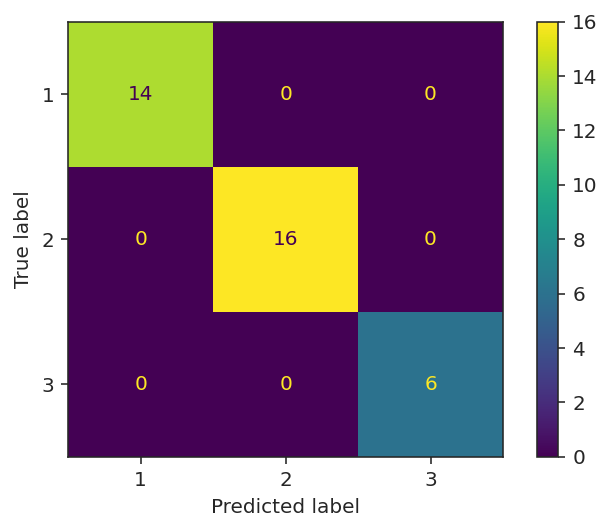

In [ ]:
# Matriz de confusión modelo 1 iris
cm_vinos= confusion_matrix(y_test_vinos, preds_vinos, labels = modelo_vinos.classes_)
# Solución gráfica
ConfusionMatrixDisplay(confusion_matrix=cm_vinos, display_labels=modelo_vinos.classes_).plot();

### Validación del modelo

Aunque hemos obtenido una clasificación perfecta resulta necesario realizar un proceso de validación para estudiar la estabilidad en la estimación de la exactitud. 

In [ ]:
# Obtenemos los scores de validación
score_val = pd.DataFrame(cross_val_score(modelo_vinos, X_train_vinos, y_train_vinos, cv=10, scoring ='accuracy'), columns=['score'])
# Describios los valores obtenidos
score_val.describe().T

,count,mean,std,min,25%,50%,75%,max
score,10.0,0.971905,0.036297,0.928571,0.929762,1.0,1.0,1.0


La exactitud media para las 10 muestras de validación se sitúa en el 97%, lo que indica que el algoritmo tien un gran poder de clasificación a partir de la información contenida en las predictoras. Dado el alto poder de clasificación del modelo no se considera necesario analizar la curva de aprendizaje. 

# <font color="steelblue">Referencias y enlaces de interés</font>






http://rasbt.github.io/mlxtend/user_guide/classifier/SoftmaxRegression/

https://www.datasklr.com/logistic-regression/multinomial-logistic-regression

http://alejandrosanchezyali.blogspot.com/2021/02/regresion-logistica-multinomial.html

https://machinelearningmastery.com/multinomial-logistic-regression-with-python/



Manuales

* Aurélien Géron (2019). Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems. O’Reilly Media.

* Peters Morgan (2018). Data Analysis From Scratch With Python: Beginner Guide using Python, Pandas, NumPy, Scikit-Learn, IPython, TensorFlow and Matplotlib. AI Sciences LLC.

* Sebastian Raschka, Vahid Mirjalili (2017). Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow. Packt Publishing.

* Julian Avila (2017). Scikit-Learn Cookbook: Over 80 Recipes for Machine Learning in Python With Scikit-Learn. Packt Publishing

* Raschka, Sebastian (2018) MLxtend: Providing machine learning and data science utilities and extensions to Python's scientific computing stack. J Open Source Softw 3(24).

Enlaces

* Microsoft: https://github.com/microsoft/ML-For-Beginners/tree/main/2-Regression/4-Logistic

* Scikit-Learn. Logistic regression: https://scikit-learn.org/stable/modules/linear_model.html?highlight=logistic#logistic-regression

* Nyandwi, J.D. Mahine Learning Complete. Linear Models for Classification: https://github.com/Nyandwi/machine_learning_complete/blob/main/6_classical_machine_learning_with_scikit-learn/2_linear_models_for_classification.ipynb

* Amat, J. (2020). https://www.cienciadedatos.net/documentos/py17-regresion-logistica-python.html